Get the data on fragments of glass
collected in forensic work from the book website.
Estimate the density of the first variable
(refractive index) using a histogram and
a kernel density estimator.
Use cross-validation to choose the amount of smoothing.
Experiment with different binwidths and bandwiths.
Comment on the similarities and differences.
Construct 95 percent confidence bands for your estimators.

The data may be found at https://www.stat.cmu.edu/~larry/all-of-statistics/=data/glass.dat

In [9]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

In [10]:
# Read the data into a pandas data frame
glass_df = pd.read_csv('../data/glass_clean.dat', sep='\t')

# Transform the single dataframe column into a numpy array
glass_data = glass_df['RI'].to_numpy()

## Histogram estimator

### Auxiliary functions

In `cv_risk` below the cross-validation estimate of the risk is computed using the identity
$$
    \hat J (m) = \frac{2m}{n-1} - \frac{m(n+1)}{n-1} \sum_{j=1}^m \hat p_j
$$
(recall that $m = 1 / h$).

In [11]:
def normalize(data):
    """
    Normalize a one-dimensional numpy array
    by shifting and rescaling all elements.
    The elements of the new array will be in [0, 1]
    """
    
    data_min = data.min()
    data_max = data.max()
    normalized_data = (data - data_min)/(data_max - data_min)
    
    return normalized_data

def cv_risk(data, m):
    """
    Computes the leave-one-out cross-validation
    estimate of the histogram risk
    (using the identity recorded in the cell above).
    
    The elements of the one-dimensional array data
    must be in [0, 1].
    
    Arguments:
    data     one-dimensional numpy array
    m        number of histogram bins
             (inverse of the binwidth)
           
    Returns:
    cv_est   leave-one-out cross-validation
             estimate of the histogram risk
    """
    
    # Number of samples
    n = len(data)
    
    # Histogram estimator
    counts, _ = np.histogram(data, bins=m)
    values_p_j = counts/n # Values of p_j, not of the density
    
    # Cross-validation risk estimate
    cv_risk = m/(n-1)*(2 - (n+1)*np.sum(values_p_j**2))

    return cv_risk

def create_cv_risk_list(data):
    """
    Compute the leave-on-out cross-validation
    estimate of the histogram risk for m ranging
    from 1 to the number of samples.
    
    Return both the list of m values and
    the list of cv_risk values to make plotting easier.
    """
    
    # Number of samples
    n = len(data)
    
    # Number of bins to use
    m_list = np.arange(1, n)
    
    # Normalize the data
    normalized_data = normalize(data)

    # Leave-one-out cross-validation estimate
    # for each number of bins
    cv_risk_list = np.array([
        cv_risk(normalized_data, m)
        for m in m_list
    ])
    
    return m_list, cv_risk_list

def plot_cv_risk(data):
    """
    Plot the leave-one-out cross-validation
    estimate of the histogram risk.
    """
    m_list, cv_risk_list = create_cv_risk_list(data)
    plt.plot(m_list, cv_risk_list, label='Cross-validation risk as a function of the number of bins')
    plt.legend(loc='best')
    plt.show()
    plt.close()

class HistogramEstimator():
    
    def __init__(self, number_of_bins, width, bin_edges, values_p_j, density):
        self.number_of_bins = number_of_bins
        self.width = width
        self.bin_edges = bin_edges
        self.values_p_j = values_p_j
        self.density = density
        
    def plot(self, axis):
        axis.bar(self.bin_edges[:-1], self.density, width=self.width, align='edge', density=True)
        
    def copy_with_new_density(self, new_density):
        """
        Copies the current HistogramEstimator object,
        changing its density to be the argument new_density.
        
        The attribute values_p_j is changed correspondingly,
        all other attributes remain the same.
        """
        
        new_values_p_j = new_density*self.bin_width
        return HistogramEstimator(
            self.number_of_bins,
            self.width,
            self.bin_edges,
            new_values_p_j,
            new_density
        )

    def create(data):
        """
        Returns an HistogramEstimator object
        given a one-dimensional numpy array.

        The number of bins is selected by minimizing
        the leave-one-out cross-validation estimate
        of the histogram risk.
        """

        # Number of samples
        n = len(data)

        # Normalize the data
        normalized_data = normalize(data)

        # Find the number of bins minimizing
        # the leave-one-out cross-validation estimate
        # of histogram risk
        m_list, cv_risk_list = create_cv_risk_list(data)
        m_optimal = m_list[cv_risk_list.argmin()]

        # Compute the histogram (for the *original*, un-normalized data)
        counts, bin_edges = np.histogram(data, bins=m_optimal)
        values = counts/n # Values of p_j, not of the density

        # Compute the values of the density itself
        # (which is interval-wise a multiple of p_j)
        width = (data.max() - data.min())/m_optimal
        density = values/width

        return HistogramEstimator(m_optimal, width, bin_edges, values, density)

def histogram_confidence_band(hist_est, n, alpha=0.05):
    """
    Returns a (1-alpha) confidence band for a histogram estimator.
    
    Arguments:
    hist_est     HistogramEstimator object
    n            number of samples
    alpha        number between 0 and 1
    
    Returns:
    Pair (2-tuple) of HistogramEstimator objects,
    the lower bound and the upper bound (in that order).
    """
    
    m = hist_est.number_of_bins
    c = (1/2)*scipy.stats.norm.isf(alpha/(2*m))*np.sqrt(m/n)
    
    lower_bound = hist_est.copy_with_new_density(
        np.maximum(np.sqrt(hist_est.density) - c, 0)**2
    )
    upper_bound = hist_est.copy_with_new_density(
        (np.sqrt(hist_est.density) + c)**2
    )
    
    return (lower_bound, upper_bound)

### Performing the histogram estimation

In [12]:
counts, bin_edges = np.histogram(glass_data, 5)

The optimal number of bins (per cross-validation) is 34.


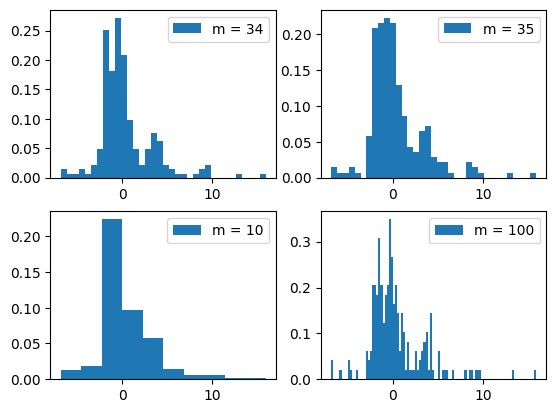

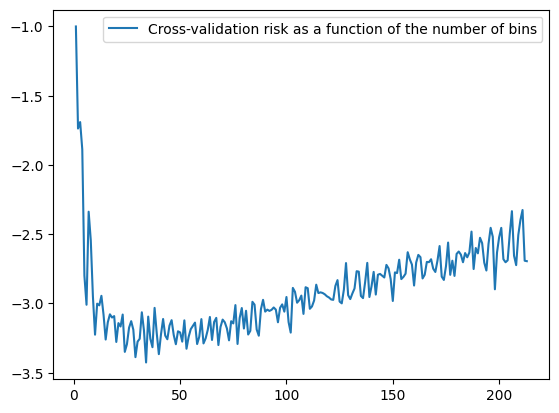

In [19]:
hist_est = HistogramEstimator.create(glass_data)
print(f"The optimal number of bins (per cross-validation) is {hist_est.number_of_bins}.")

m_list = [hist_est.number_of_bins, 35, 10, 100]

fig, axs = plt.subplots(2, 2)
for axis, m in list(zip(axs.reshape(4), m_list)):
    axis.hist(glass_data, m, density=True, label=f"m = {m}")
    axis.legend(loc='best')
plt.show()
plt.close()
    
plot_cv_risk(glass_data)

### Histogram estimation - Summary of results

We observe the following.
1. When the number of bins is too small
   (i.e. the binwidth is too large, or equivalently
   the amount of smoothing is too high)
   some features are erased.
   For example the twin peaks around zero merge into one when m = 10.
1. When the number of bins is too large
   (i.e. the binwidth is too small, or equivalently
   the amount of smoothing is too low)
   some features appear which may be artifacts of the sample,
   and not of the underlying distribution.
   We see this in the histogram with m = 100 above.
1. Even when the number of bins is **very close**
   to the optimal number of bins, the features of
   the resulting histogram estimator may vary significantly.
   For example the twin peaks near zero are visible when m = 34,
   which is optimal, but merge when m = 35.
   This is because the leave-one-out cross-validation
   estimate of the histogram risk has significant oscillations.

### Confidence band for the histogram estimation

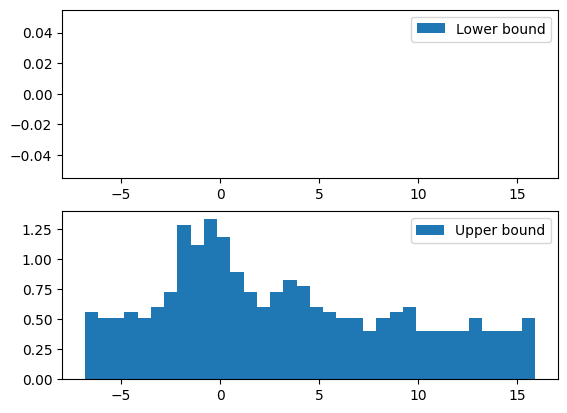

In [26]:
hist_est = HistogramEstimator.create(glass_data)
n = len(glass_data)

(lower_bound, upper_bound) = histogram_confidence_band(hist_est, n)

fig, axs = plt.subplots(2)
for plot, hist_est, label_text in (
    (axs[0], lower_bound, "Lower bound"),
    (axs[1], upper_bound, "Upper bound"),
):
    plot.bar(
        hist_est.bin_edges[:-1],
        hist_est.density,
        width=hist_est.width,
        align='edge',
        label=label_text
    )
    plot.legend(loc='best')
plt.show()
plt.close()

### Confidence band for the histogram estimation - Summary of results

The confidence band above is **very large**
(the lower bound is uniformly 0!)

With 214 data points, we have little guarantee
that the histogram estimator is close to the true density.

## Kernel density estimator

### Auxiliary functions

We only implement kernel density estimation using the *Gaussian* kernel.
This is because the Gaussian kernel is closed under convolution:
the convolution of two Gaussian kernels remains a Gaussian kernel
(actually, it appears that the Gaussian kernel is the only kernel
with finite variance with this property since it is the only
[stable distribution](https://en.wikipedia.org/wiki/Stable_distribution) with finite variance).

To compute the approximation of the leave-one-out cross-validation
estimate of the risk of the kernel density estimator in `kde_cv_risk`
we use the approximation
$$
    \hat J (h)
    \approx
    \frac{1}{nh^2} \sum_{i,j=1}^n K^* \left( \frac{x - X_i}{h} \right)
    + \frac{2}{nh} K(0)
$$
where $K^* = K^{(2)} - 2 K$ for $K^{(2)} = K \ast K$ such that,
for the Gaussian kernel $K$, $K^{(2)}$ is the PDF of a $N(0,2)$ random variable.

In [15]:
def kde_cv_risk(data, h):
    """
    Approximate estimate of the leave-one-out
    cross-validation estimate of the risk of
    the kernel density estimator
    for a given bandwidth h.
    """
    # Gaussian kernel and corresponding K_star
    K = scipy.stats.norm.pdf
    K_star = lambda x : scipy.stats.norm.pdf(x, scale=np.sqrt(2)) - 2 * scipy.stats.norm.pdf(x)
    
    cv_risk = (
        np.sum(K_star(
            np.tile(data, (n, 1)) - np.tile(data.reshape(n, 1), (1, n)) / h
        ))/(n**2*h)
        + 2*K(0)/(n*h)
    )
    
    return cv_risk

def create_kde_cv_risk_list(data):
    """
    Compute the approximation of the leave-on-out
    cross-validation estimate of the risk
    of the kernel density estimator
    for the bandwidth h ranging from 0.01 to 2.00.
    
    Return both the list of h values and
    the list of cv_risk values to make plotting easier.
    """
    
    # Number of samples
    n = len(data)
    
    # Bandwidths
    h_list = np.arange(start=0.01, stop=2, step=0.01)

    # Approximation of the leave-one-out
    # cross-validation estimate of the risk
    cv_risk_list = np.array([
        kde_cv_risk(data, h)
        for h in h_list
    ])
    
    return h_list, cv_risk_list

def plot_kde_cv_risk(data):
    """
    Plot the approximation of the leave-one-out
    cross-validation estimate of the risk of
    the kernel density estimator.
    """
    h_list, cv_risk_list = create_kde_cv_risk_list(data)
    plt.plot(h_list, cv_risk_list, label='Cross-validation risk approximation\nas a function of the bandwidth')
    plt.legend(loc='best')
    plt.show()
    plt.close()
    
class KernelDensityEstimator():
    
    def __init__(self, kernel, bandwidth, data):
        self.kernel = kernel
        self.bandwidth = bandwidth
        self.data = data
        
    def evaluate(self, x_arr):
        """
        Evaluate the kernel density estimator
        at every point in the one-dimensional array x_arr.
        """
        
        kde_arr = np.array([
            np.mean(
                self.kernel(
                    (x - self.data)/self.bandwidth
                )/self.bandwidth
            )
            for x in x_arr
        ])
        
        return kde_arr
    
    def plot(self, x_arr, axis):
        """
        Plot the kernel density estimator
        over the domain sampled by x_arr.
        """
        axis.plot(x_arr, self.evaluate(x_arr), label=f"h = {self.bandwidth}")
        
    def create(data):
        """
        Returns a KernelDensityEstimator object
        given a one-dimensional numpy array.

        The bandwidth is selected by minimizing
        the approximation of the leave-one-out
        cross-validation estimate of the risk
        of the kernel density estimator.

        The kernel is the Gaussian kernel.
        """

        # Number of samples
        n = len(data)

        # Find the number of bins minimizing
        # the leave-one-out cross-validation estimate
        # of histogram risk
        h_list, cv_risk_list = create_kde_cv_risk_list(data)
        h_optimal = h_list[cv_risk_list.argmin()]

        # Gaussian kernel
        K = scipy.stats.norm.pdf

        return KernelDensityEstimator(K, h_optimal, data)

### Performing the kernel density estimation

The optimal bandwidth (per cross-validation) is h = 0.22.


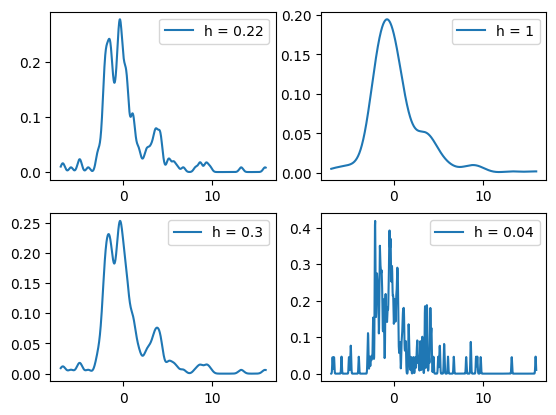

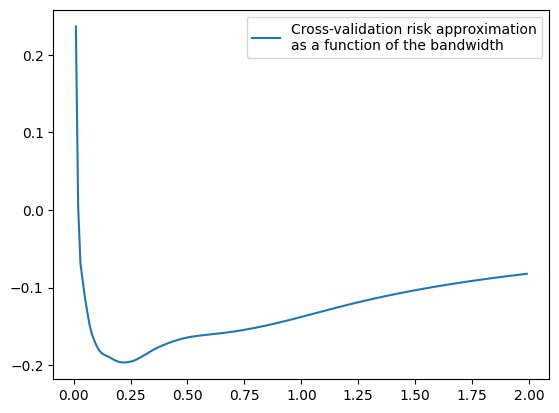

In [28]:
x_arr = np.linspace(-7, 16, num=1000)

kde = KernelDensityEstimator.create(glass_data)
print(f"The optimal bandwidth (per cross-validation) is h = {kde.bandwidth}.")

K_gauss = scipy.stats.norm.pdf
h_list = [0.22, 1, 0.3, 0.04]

fig, axs = plt.subplots(2, 2)
for axis, h in zip(axs.reshape(4), h_list):
    current_kde = KernelDensityEstimator(K_gauss, h, glass_data)
    current_kde.plot(x_arr, axis)
    axis.legend(loc='best')
plt.show()
plt.close()

plot_kde_cv_risk(glass_data)

### Kernel density estimation - Summary of results

1. Similarly to *histogram* estimation,
   the amount of smoothing in *kernel density* estimation
   may hide certain features of the PDF (when the amount of smoothing is too high)
   or suggest spurious features (when the amount of smoothing is too low).
1. A significant difference with histogram estimation
   is that, here, the approximation of the cross-validation
   risk estimate various smoothly as a function of
   the parameter (the bandwidth, in this case).